# Chapter 2: End-to-End Machine Learning Project - Notebook Reproduksi Kode

Bab ini membawa kita melalui proyek Machine Learning yang lengkap,
dari mendapatkan data hingga menyempurnakan model.

Dataset: California Housing Prices dari StatLib repository (data sensus 1990).
Tujuan: Memprediksi harga rumah median di setiap distrik.

Data diunduh dan diekstrak ke: datasets/housing

--- Data Dimuat (5 Baris Teratas): ---
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0      

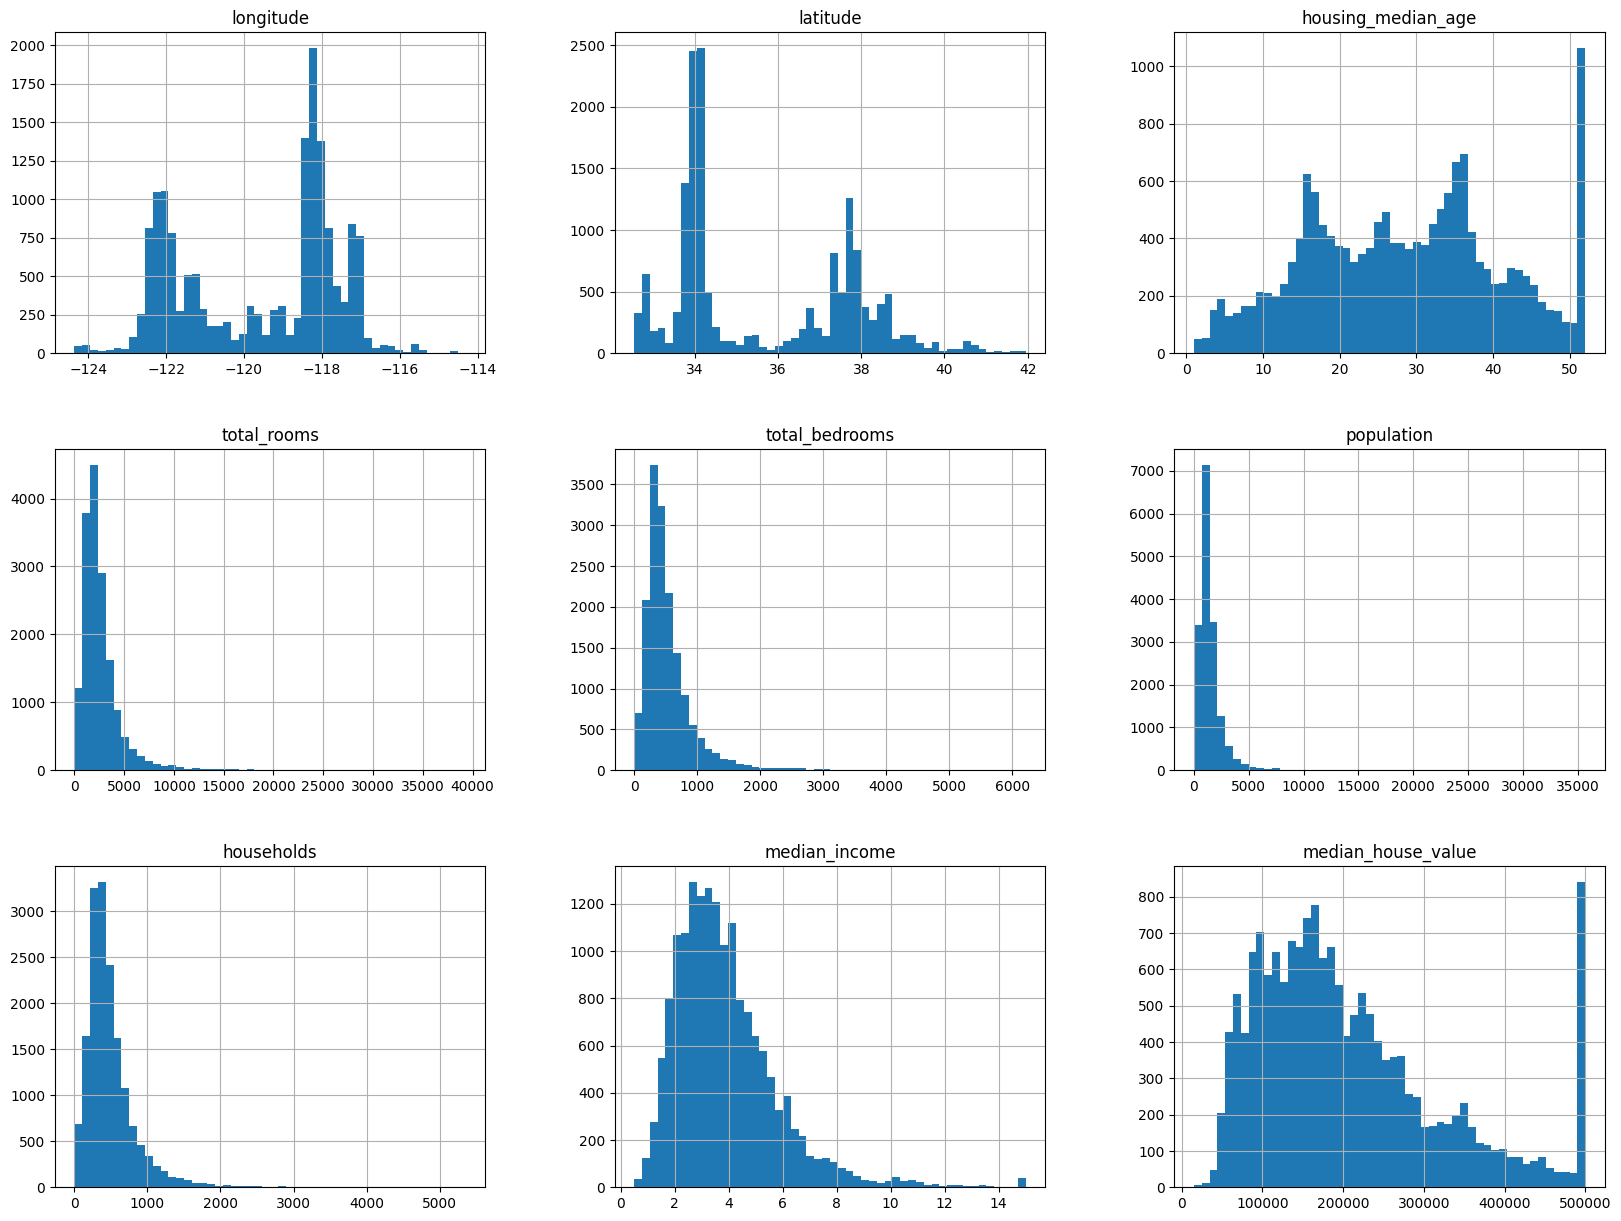


--- Scatter Plot Geografis Kepadatan: ---


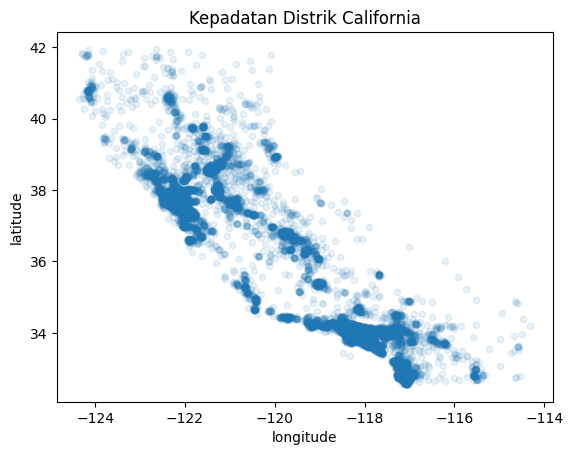


--- Scatter Plot Harga Rumah berdasarkan Lokasi dan Populasi: ---


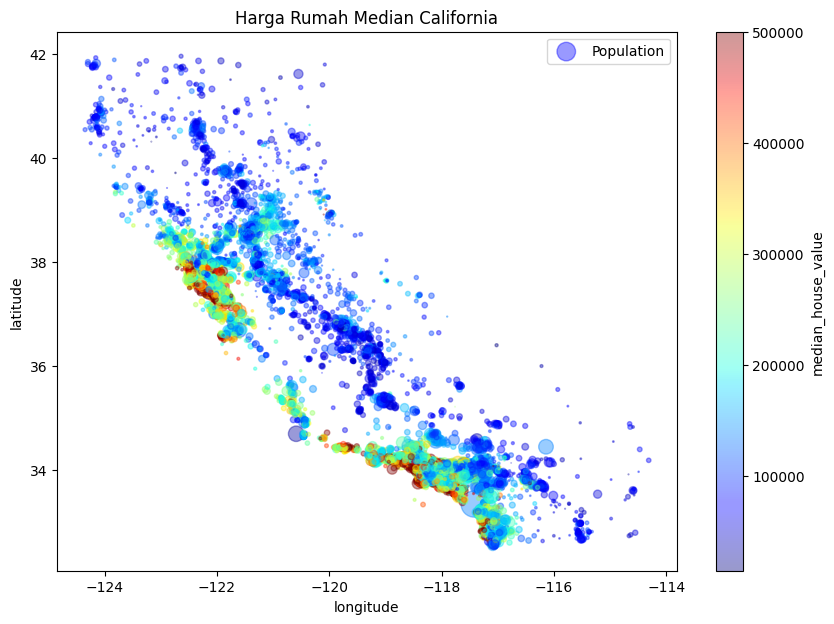


--- Matriks Korelasi dengan 'median_house_value': ---
median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

--- Scatter Matrix untuk Atribut Terpilih: ---


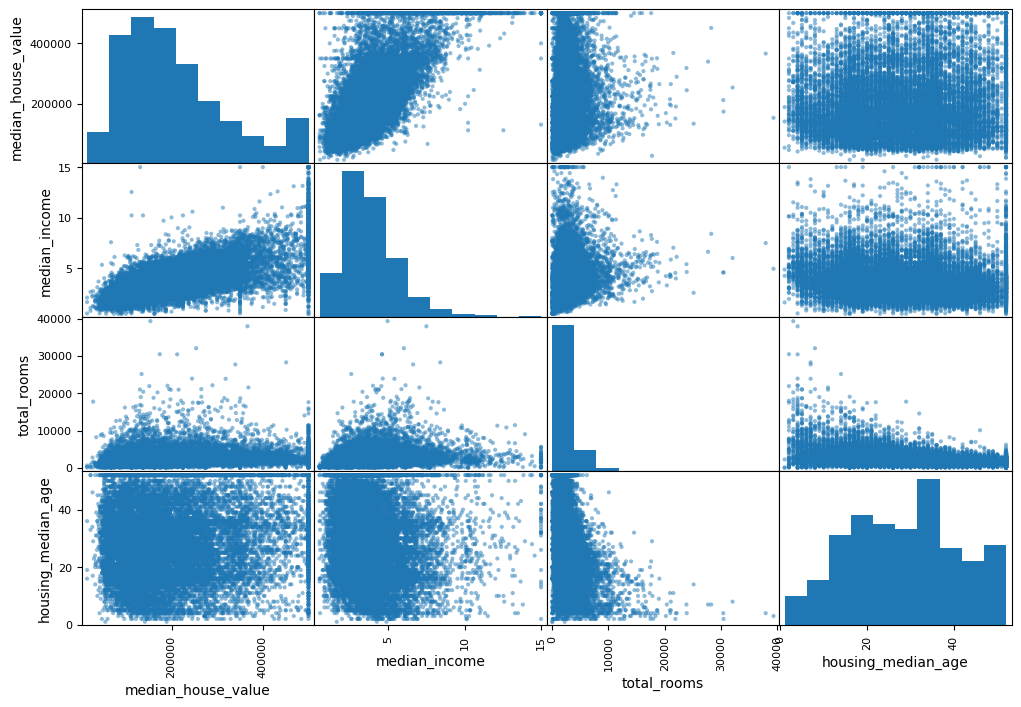


--- Scatter Plot: Pendapatan Median vs. Harga Rumah Median: ---


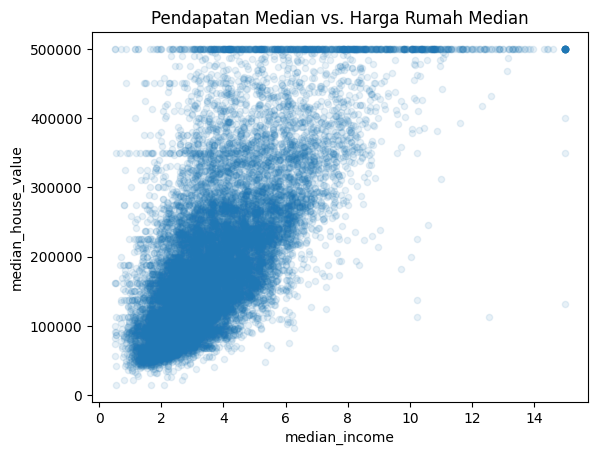


--- Matriks Korelasi dengan Atribut Gabungan: ---
median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

--- Contoh Data Numerik Setelah Imputasi (Head): ---
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.7

In [7]:
# -*- coding: utf-8 -*-
"""
Chapter 2: End-to-End Machine Learning Project - Notebook Reproduksi Kode

Bab ini membawa kita melalui proyek Machine Learning yang lengkap,
dari mendapatkan data hingga menyempurnakan model.

Dataset: California Housing Prices dari StatLib repository (data sensus 1990).
Tujuan: Memprediksi harga rumah median di setiap distrik.
"""

import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Untuk visualisasi tambahan
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
# FIX: ColumnTransformer dipindahkan dari sklearn.pipeline ke sklearn.compose di versi Scikit-Learn tertentu
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # Impor ColumnTransformer dari sklearn.compose
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib # Untuk menyimpan/memuat model

# --- 1. Mendapatkan Data ---
# Bagian ini mereplikasi fungsi pengunduhan data dari buku.

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    print(f"Data diunduh dan diekstrak ke: {housing_path}")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Panggil fungsi untuk mengunduh dan memuat data
fetch_housing_data()
housing = load_housing_data()

print("\n--- Data Dimuat (5 Baris Teratas): ---")
print(housing.head())

# --- 2. Mengintip Struktur Data ---
# Memahami data dengan cepat.

print("\n--- Info Data: ---")
housing.info()

print("\n--- Nilai Unik 'ocean_proximity': ---")
print(housing["ocean_proximity"].value_counts())

print("\n--- Statistik Deskriptif: ---")
print(housing.describe())

# --- 3. Membagi Data Menjadi Set Pelatihan dan Pengujian ---
# Penting untuk melakukannya di awal untuk menghindari data snooping bias.
# Menggunakan Stratified Sampling berdasarkan kategori pendapatan.

# Buat kategori pendapatan
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

print("\n--- Distribusi Kategori Pendapatan: ---")
print(housing["income_cat"].value_counts() / len(housing))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Hapus kolom income_cat karena hanya untuk stratified sampling
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(f"\nUkuran set pelatihan: {len(strat_train_set)}")
print(f"Ukuran set pengujian: {len(strat_test_set)}")

# --- 4. Eksplorasi dan Visualisasi Data untuk Wawasan ---
# Bekerja pada salinan set pelatihan.

housing = strat_train_set.copy()

# Histograms
print("\n--- Histograms Atribut Numerik: ---")
housing.hist(bins=50, figsize=(20, 15))
plt.show()

# Scatter plot geografis
print("\n--- Scatter Plot Geografis Kepadatan: ---")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.title("Kepadatan Distrik California")
plt.show()

# Scatter plot harga rumah (populasi dan nilai rumah)
print("\n--- Scatter Plot Harga Rumah berdasarkan Lokasi dan Populasi: ---")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="Population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.title("Harga Rumah Median California")
plt.legend()
plt.show()

# Matriks Korelasi (Pearson's r)
print("\n--- Matriks Korelasi dengan 'median_house_value': ---")
corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# Scatter Matrix untuk atribut yang menjanjikan
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
print("\n--- Scatter Matrix untuk Atribut Terpilih: ---")
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

# Zoom in pada korelasi median_income vs. median_house_value
print("\n--- Scatter Plot: Pendapatan Median vs. Harga Rumah Median: ---")
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.title("Pendapatan Median vs. Harga Rumah Median")
plt.show()

# Eksperimen dengan kombinasi atribut
print("\n--- Matriks Korelasi dengan Atribut Gabungan: ---")
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# --- 5. Menyiapkan Data untuk Algoritma Machine Learning ---
# Pisahkan fitur dan label
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Penanganan Nilai yang Hilang (Imputasi)
# Menggunakan SimpleImputer untuk mengisi nilai yang hilang dengan median.
# Data numerik saja untuk imputer.
housing_num = housing.select_dtypes(include=[np.number]) # Hanya kolom numerik

imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num) # Pelajari median dari data pelatihan
X_num_imputed = imputer.transform(housing_num)
housing_tr_num = pd.DataFrame(X_num_imputed, columns=housing_num.columns,
                              index=housing_num.index)
print("\n--- Contoh Data Numerik Setelah Imputasi (Head): ---")
print(housing_tr_num.head())


# Mengelola Atribut Teks dan Kategorikal (OneHotEncoding)
housing_cat = housing[["ocean_proximity"]]
print("\n--- Contoh Atribut Kategorikal (Head): ---")
print(housing_cat.head())

one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)
print("\n--- Contoh Atribut Kategorikal Setelah One-Hot Encoding (Array): ---")
print(housing_cat_1hot.toarray()[:5])
print(f"Kategori yang ditemukan: {one_hot_encoder.categories_}")

# Transformer Kustom (gabungan atribut)
# Ini adalah kelas transformer kustom yang sama dengan yang ada di buku.
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 # Indeks kolom setelah imputasi

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # Nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Pipelines Transformasi Penuh
# Gabungkan semua langkah preprocessing ke dalam satu pipeline.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# Identifikasi kolom numerik dan kategorikal dari data asli (sebelum drop label)
num_attribs = list(housing.select_dtypes(include=[np.number]).columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs), # handle_unknown untuk kategori baru
])

# Jalankan pipeline penuh pada data pelatihan
housing_prepared = full_pipeline.fit_transform(strat_train_set)

print(f"\nBentuk data setelah preprocessing penuh: {housing_prepared.shape}")
print("Contoh data yang telah disiapkan (5 baris pertama, menunjukkan sparse matrix jika ada):")
print(housing_prepared[:5])


# --- 6. Memilih dan Melatih Model ---

# Model 1: Regresi Linier
print("\n--- Melatih Model Regresi Linier: ---")
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Evaluasi pada set pelatihan (RMSE)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f"RMSE Regresi Linier (Pelatihan): {lin_rmse:.2f}")

# Model 2: Pohon Keputusan
print("\n--- Melatih Model Pohon Keputusan: ---")
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

# Evaluasi pada set pelatihan (RMSE) - Perhatikan potensi overfitting
housing_predictions_tree = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
print(f"RMSE Pohon Keputusan (Pelatihan): {tree_rmse:.2f}")

# Evaluasi dengan Cross-Validation
# Regresi Linier
print("\n--- Evaluasi Regresi Linier dengan Cross-Validation: ---")
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print(f"Scores (10 fold): {lin_rmse_scores}")
print(f"Mean Score: {lin_rmse_scores.mean():.2f}")
print(f"Std Dev Score: {lin_rmse_scores.std():.2f}")

# Pohon Keputusan
print("\n--- Evaluasi Pohon Keputusan dengan Cross-Validation: ---")
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
print(f"Scores (10 fold): {tree_rmse_scores}")
print(f"Mean Score: {tree_rmse_scores.mean():.2f}")
print(f"Std Dev Score: {tree_rmse_scores.std():.2f}")

# Model 3: Random Forest
print("\n--- Melatih Model Random Forest: ---")
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# Evaluasi dengan Cross-Validation
print("\n--- Evaluasi Random Forest dengan Cross-Validation: ---")
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print(f"Scores (10 fold): {forest_rmse_scores}")
print(f"Mean Score: {forest_rmse_scores.mean():.2f}")
print(f"Std Dev Score: {forest_rmse_scores.std():.2f}")

# --- 7. Penyetelan (Fine-tuning) Model ---
# Menggunakan GridSearchCV untuk Random Forest

print("\n--- Menyetel Hyperparameter Random Forest dengan GridSearchCV: ---")
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg_tuned = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg_tuned, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1, verbose=2) # n_jobs=-1 untuk semua core

grid_search.fit(housing_prepared, housing_labels)

print(f"\nBest hyperparameters ditemukan: {grid_search.best_params_}")
print(f"Estimator terbaik: {grid_search.best_estimator_}")

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f"RMSE: {np.sqrt(-mean_score):.2f}, Params: {params}")

final_model = grid_search.best_estimator_
print(f"\nModel terbaik setelah penyetelan: {final_model}")

# --- 8. Evaluasi Sistem pada Set Pengujian ---

print("\n--- Evaluasi Akhir pada Set Pengujian: ---")
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Preproses data pengujian menggunakan pipeline yang sudah dilatih (TIDAK fit_transform)
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"RMSE Final pada Set Pengujian: {final_rmse:.2f}")

# Simpan model final
joblib.dump(final_model, "final_housing_model.pkl")
print("\nModel final disimpan sebagai 'final_housing_model.pkl'")

print("\n--- Proyek Pembelajaran Mesin End-to-End Selesai ---")

